In [2]:
import json
import os

path = "/proj/mechanistic.shadow/mrofin/tinylinguist/models/"

texts = []

dirs = os.listdir(path)
for model_dir in dirs:
    if model_dir.startswith("checkpoint"):
        with open(os.path.join(path, model_dir, "generation_results.json")) as f:
            cur_texts = json.load(f)
            cur_texts["step"] = int(model_dir.split("-")[1])
            texts.append(cur_texts)

In [11]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/local/mrofin/anaconda3/envs/brenv/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
import numpy as np

golden_embeddings = model.encode(texts[0]["golden"])
np.save("/proj/mechanistic.shadow/mrofin/tinylinguist/data/golden_embeddings.npy", golden_embeddings)

In [15]:
from tqdm import tqdm

for cur_texts in tqdm(texts):
    step = cur_texts["step"]
    cur_embeddings = model.encode(cur_texts["generated"])
    np.save(f"/proj/mechanistic.shadow/mrofin/tinylinguist/data/{step}_embeddings.npy", cur_embeddings)

100%|██████████| 67/67 [10:09<00:00,  9.10s/it]


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

accs = []

for step in tqdm([d["step"] for d in texts]):
    np.random.seed(42)

    gen_embeddings = np.load(f"/proj/mechanistic.shadow/mrofin/tinylinguist/data/{step}_embeddings.npy")
    X = np.concatenate([golden_embeddings, gen_embeddings])
    y = np.array([0] * len(golden_embeddings) + [1] * len(gen_embeddings))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2000, stratify=y, shuffle=True)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)

    accs.append({"step": step, "accuracy": acc})

import json
with open("/proj/mechanistic.shadow/mrofin/tinylinguist/data/discriminator_accuracy.json", "w") as f:
    json.dump(accs, f)

100%|██████████| 67/67 [00:20<00:00,  3.27it/s]


<Axes: xlabel='step', ylabel='accuracy'>

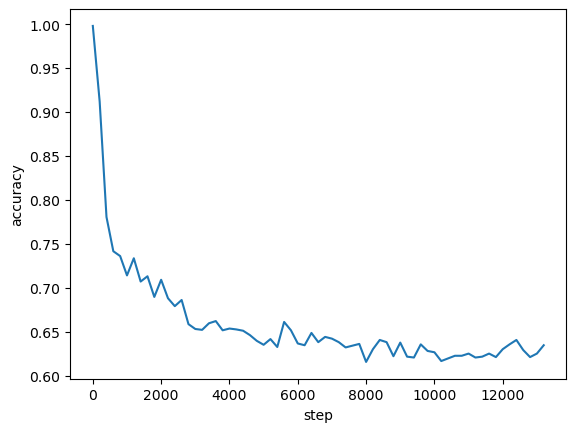

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

accs_pd = pd.DataFrame(accs)

sns.lineplot(x="step", y="accuracy", data=accs_pd)